In [1]:
%matplotlib notebook
%autosave 0
%load_ext autoreload
%autoreload 2
#%matplotlib inline
import numpy as np
from numpy.random import RandomState
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import animation
#from os.path import join
#import ipywidgets as widgets
from IPython.display import display
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable
import pickle
#from sklearn import svm, datasets
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix, classification_report
from tqdm.notebook import tqdm

Autosave disabled


In [2]:
import sys
sys.path.append("../imbalanced_dataset_sampler/torchsampler/")
sys.path.append("../libs")
from vvv_utils import parse_metadata, parse_light_curve_data, plot_light_curve, get_train_test_ids
from imbalanced import ImbalancedDatasetSampler


### Parse Metadata

In [3]:
df_meta = parse_metadata(experiment="ALL", merge_subclasses=True)
class_names = df_meta["label"].unique()
display(df_meta.head(5))

88454 light curve metadata collected


,P1,P2,P_ogle,label
ID_VVV,,,,
b221_201_22183,13.972335,6.986167,13.970992,binary
b221_205_41463,21.537799,10.770059,21.541892,binary
b232_614_24529,8.035356,16.069420,16.065114,binary
b233_201_30278,8.750438,4.374645,8.751487,binary
b233_201_16631,44.130627,22.070183,44.161985,binary


In [4]:
indices_vvv = np.arange(len(df_meta))
#indices_vvv

In [5]:
df_meta["idx"] = indices_vvv
df_meta = df_meta.reset_index()
df_meta


,ID_VVV,P1,P2,P_ogle,label,idx
0,b221_201_22183,13.972335,6.986167,13.970992,binary,0
1,b221_205_41463,21.537799,10.770059,21.541892,binary,1
2,b232_614_24529,8.035356,16.069420,16.065114,binary,2
3,b233_201_30278,8.750438,4.374645,8.751487,binary,3
4,b233_201_16631,44.130627,22.070183,44.161985,binary,4
...,...,...,...,...,...,...
88449,b395_201_28153,0.316792,0.633585,0.316787,rrlyrae,88449
88450,b395_205_6265,0.287350,0.574699,0.287350,rrlyrae,88450
88451,b395_304_9934,0.355847,0.711693,0.355842,rrlyrae,88451
88452,b396_209_39823,0.814810,0.407405,0.407412,rrlyrae,88452


In [6]:
#df_meta = df_meta[["idx","ID_VVV","P1","P2","P_ogle","label"]]
df_meta = df_meta.set_index(df_meta["idx"])
df_meta.drop(labels="idx",axis=1,inplace=True)
df_meta

,ID_VVV,P1,P2,P_ogle,label
idx,,,,,
0,b221_201_22183,13.972335,6.986167,13.970992,binary
1,b221_205_41463,21.537799,10.770059,21.541892,binary
2,b232_614_24529,8.035356,16.069420,16.065114,binary
3,b233_201_30278,8.750438,4.374645,8.751487,binary
4,b233_201_16631,44.130627,22.070183,44.161985,binary
...,...,...,...,...,...
88449,b395_201_28153,0.316792,0.633585,0.316787,rrlyrae
88450,b395_205_6265,0.287350,0.574699,0.287350,rrlyrae
88451,b395_304_9934,0.355847,0.711693,0.355842,rrlyrae


### Definiciones de Clases, Variables, Datasets

In [7]:
lc_classes = {"label":{"binary":0, "rrlyrae":1, "cepheid":2}}

In [8]:
# Variable Categórica, reemplaza nombres por números
df_meta.replace(lc_classes,inplace=True)
df_meta

,ID_VVV,P1,P2,P_ogle,label
idx,,,,,
0,b221_201_22183,13.972335,6.986167,13.970992,0
1,b221_205_41463,21.537799,10.770059,21.541892,0
2,b232_614_24529,8.035356,16.069420,16.065114,0
3,b233_201_30278,8.750438,4.374645,8.751487,0
4,b233_201_16631,44.130627,22.070183,44.161985,0
...,...,...,...,...,...
88449,b395_201_28153,0.316792,0.633585,0.316787,1
88450,b395_205_6265,0.287350,0.574699,0.287350,1
88451,b395_304_9934,0.355847,0.711693,0.355842,1


In [9]:
# NUEVO

class LightCurve_Dataset(Dataset):
    def __init__(self, df_metadata, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["P_ogle"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        column_names_fill = ["mjd", "mag", "err", "phase", "mask"]
        df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
        
        for i in range(len(df_metadata)):
            lc_data = parse_light_curve_data(self.name[i])
            lc_data["phase"] = np.mod(lc_data["mjd"],self.period[i])/self.period[i]
            #display(lc_data)
            #normalize
            mag_std = lc_data["mag"].std()
            lc_data["mjd"] = lc_data["mjd"]-lc_data["mjd"].min()
            lc_data["mag"] = (lc_data["mag"]-lc_data["mag"].mean())/mag_std
            lc_data["err"] = lc_data["err"]/mag_std
            lc_data.sort_values(by="phase", inplace=True)
            # ajustar todas a largo 335, rellenando con 0s las que sean mas pequeñas,
            # asignando un label '1' si es dato real y '0' si es dato rellenado.
            """if len(lc_data) == 335:
                lc_data["mask"] = 1
            else:
                while len(lc_data) < 335:
                    #RELLENAR con 0s;
                    lc_data = lc_data.append(df_zeros, ignore_index=True,sort=False)
            lc_data = lc_data.fillna(1)
            lc_data = lc_data[["phase","mag","err","mjd","mask"]]
            self.data.append(torch.from_numpy(lc_data.values.astype('float32')))
            """
            lc_data = lc_data[["phase","mag","err","mjd"]]
            lc_data_large = np.zeros(shape=(335, 5), dtype='float32')
            lc_data_large[:lc_data.shape[0], :4] = lc_data.values
            lc_data_large[:lc_data.shape[0], 4] = 1.
            self.data.append(torch.from_numpy(lc_data_large))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample
    def period(self,idx):
        return self.period[idx]

    def plot(self, idx, ax):
        assert len(ax)==2, "Needs two subaxis"
        ax[0].cla()  
        ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[0].invert_yaxis()
        ax[1].cla()
        ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[1].invert_yaxis()
        ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)

In [10]:
# SIN NORMALIZAR, SIN RELLENAR CON 0s

class LightCurve_Dataset2(Dataset):
    def __init__(self, df_metadata, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["P_ogle"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        column_names_fill = ["mjd", "mag", "err", "phase", "mask"]
        df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
        
        for i in range(len(df_metadata)):
            lc_data = parse_light_curve_data(self.name[i])
            lc_data["phase"] = np.mod(lc_data["mjd"],self.period[i])/self.period[i]
            #display(lc_data)
            """
            #normalize
            mag_std = lc_data["mag"].std()
            lc_data["mjd"] = lc_data["mjd"]-lc_data["mjd"].min()
            lc_data["mag"] = (lc_data["mag"]-lc_data["mag"].mean())/mag_std
            lc_data["err"] = lc_data["err"]/mag_std
            lc_data.sort_values(by="phase", inplace=True)
            # ajustar todas a largo 335, rellenando con 0s las que sean mas pequeñas,
            # asignando un label '1' si es dato real y '0' si es dato rellenado.
            if len(lc_data) == 335:
                lc_data["mask"] = 1
            else:
                while len(lc_data) < 335:
                    #RELLENAR con 0s;
                    lc_data = lc_data.append(df_zeros, ignore_index=True,sort=False)
            lc_data = lc_data.fillna(1)
            lc_data = lc_data[["phase","mag","err","mjd","mask"]]
            self.data.append(torch.from_numpy(lc_data.values.astype('float32')))
            """
            lc_data = lc_data[["phase","mag","err","mjd"]]
            #lc_data_large = np.zeros(shape=(335, 5), dtype='float32')
            #lc_data_large[:lc_data.shape[0], :4] = lc_data.values
            #lc_data_large[:lc_data.shape[0], 4] = 1.
            self.data.append(torch.from_numpy(lc_data.values))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample
    def period(self,idx):
        return self.period[idx]

    def plot(self, idx, ax):
        assert len(ax)==2, "Needs two subaxis"
        ax[0].cla()  
        ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[0].invert_yaxis()
        ax[1].cla()
        ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[1].invert_yaxis()
        ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)

**Dataset**

Vista Variables in the Via lactea

In [ ]:
%%timeit -n 1 -r 1
#para evaluar el tiempo

In [11]:
#%%timeit -n 1 -r 1   --->  aprox 26:55 mins on Frank
VVV = LightCurve_Dataset(df_meta)

In [ ]:
# próxima ocasión CARGAR dataset desde pickle
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_withPeriod.pkl', 'rb') as handle:
    VVV = pickle.load(handle)


In [297]:
#SIN NORMALIZAR NI RELLENAR
# tarda aprox. 07:54 mins en Frank
VVV2 = LightCurve_Dataset2(df_meta)

In [ ]:
# próxima ocasión CARGAR dataset desde pickle
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_NoNorm.pkl', 'rb') as handle:
    VVV2 = pickle.load(handle)


Guardar Dataset como Pickle

In [312]:
# PICKLE SIN NORMALIZAR
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_NoNorm.pkl', 'wb') as handle:
    pickle.dump(VVV2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
# with period Julio 2020 
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_withPeriod.pkl', 'wb') as handle:
    pickle.dump(VVV, handle, protocol=pickle.HIGHEST_PROTOCOL)

Numero promedio de muestras

In [6]:
VVV[420]['data'][:,0]

tensor([0.0147, 0.0217, 0.0258, 0.0273, 0.0289, 0.0681, 0.0892, 0.0898, 0.0982,
        0.0982, 0.1062, 0.1152, 0.1235, 0.1272, 0.1314, 0.1373, 0.1445, 0.1534,
        0.1928, 0.1959, 0.2150, 0.2515, 0.2518, 0.2725, 0.2997, 0.3205, 0.3233,
        0.3487, 0.3519, 0.3601, 0.3604, 0.3862, 0.4194, 0.4350, 0.4436, 0.4565,
        0.4643, 0.4753, 0.5054, 0.5260, 0.5314, 0.5682, 0.5711, 0.5718, 0.5932,
        0.5938, 0.6031, 0.6247, 0.6454, 0.6581, 0.6919, 0.7070, 0.7114, 0.7291,
        0.7584, 0.7790, 0.7807, 0.7823, 0.7852, 0.7866, 0.7880, 0.7918, 0.7931,
        0.8167, 0.8240, 0.8315, 0.8463, 0.8529, 0.8633, 0.8732, 0.8785, 0.8864,
        0.8910, 0.9130, 0.9165, 0.9182, 0.9400, 0.9401, 0.9789, 0.9873, 0.9974,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [33]:
pares = {'si':[],'no':[]}
for i in range(20):
    if i%2==0:
        pares['si'].append(i)
    else:
        pares['no'].append(i)
pares

{'si': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18],
 'no': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}

In [34]:
muestras= {'ECL':[],'RRL':[],'CEP':[]}
for i in VVV:
    if (i['label'].item() == 0):
        muestras['ECL'].append(i['data'][:,4].sum().item())
    elif i['label'].item() == 1:
        muestras['RRL'].append(i['data'][:,4].sum().item())
    elif i['label'].item() == 2:
        muestras['CEP'].append(i['data'][:,4].sum().item())
muestras

{'ECL': [79.0,
  79.0,
  74.0,
  76.0,
  76.0,
  75.0,
  77.0,
  77.0,
  75.0,
  76.0,
  75.0,
  77.0,
  76.0,
  78.0,
  77.0,
  77.0,
  75.0,
  76.0,
  75.0,
  77.0,
  76.0,
  78.0,
  72.0,
  70.0,
  69.0,
  70.0,
  70.0,
  78.0,
  73.0,
  73.0,
  73.0,
  72.0,
  72.0,
  72.0,
  72.0,
  72.0,
  73.0,
  74.0,
  74.0,
  74.0,
  75.0,
  75.0,
  75.0,
  75.0,
  75.0,
  74.0,
  75.0,
  75.0,
  75.0,
  75.0,
  75.0,
  75.0,
  75.0,
  76.0,
  76.0,
  76.0,
  76.0,
  75.0,
  73.0,
  73.0,
  75.0,
  75.0,
  75.0,
  77.0,
  76.0,
  76.0,
  77.0,
  77.0,
  74.0,
  76.0,
  75.0,
  76.0,
  77.0,
  76.0,
  76.0,
  76.0,
  76.0,
  76.0,
  77.0,
  77.0,
  77.0,
  84.0,
  84.0,
  84.0,
  85.0,
  83.0,
  84.0,
  84.0,
  84.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  83.0,
  72.0,
  72.0,
  72.0,
  72.0,
  73.0,
  73.0,
  71.0,
  71.0,
  72.0,
  70.0,
  68.0,
  69.0,
  69.0,
  69.0,
  69.0,
  74.0,
  74.0,
  74.0,
  74.0,
  74.0,
  74.0,
  74.0,
  74.0,
  74.0,
 

<IPython.core.display.Javascript object>


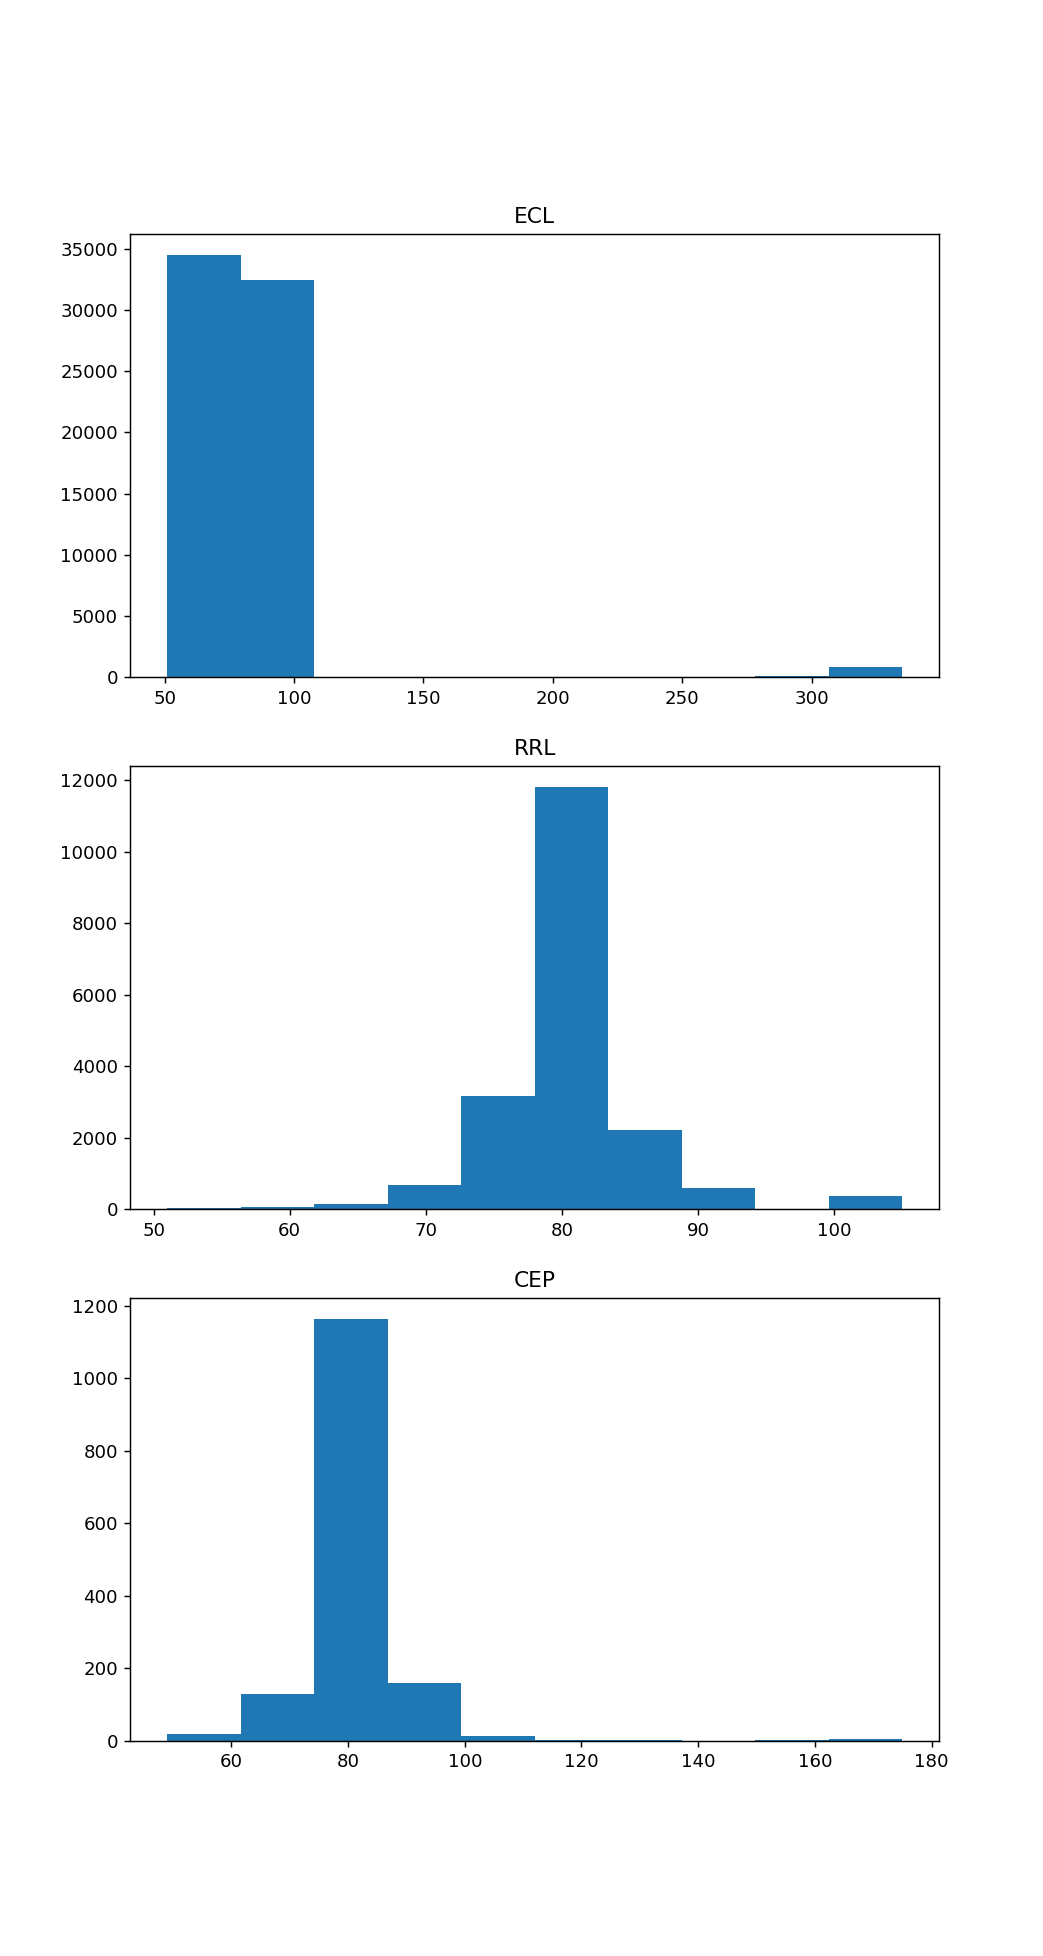

In [36]:
fig, ax = plt.subplots(3,1,figsize=(8,5*3))
for i in [0,1,2]:
    if i==0:
        ax[i].hist(muestras['ECL'])
        ax[i].set_title('ECL')
    elif i==1:
        ax[i].hist(muestras['RRL'])
        ax[i].set_title('RRL')
    else:
        ax[i].hist(muestras['CEP'])
        ax[i].set_title('CEP')

plt.show()

In [37]:
muestras['ECL'] = np.array(muestras['ECL'])
muestras['RRL'] = np.array(muestras['RRL'])
muestras['CEP'] = np.array(muestras['CEP'])

In [40]:
for i in ['ECL','RRL','CEP']:
    display(i, muestras[i].mean(),muestras[i].std())


'ECL'

82.52321247034904

28.76462951967974

'RRL'

80.38015403153979

5.635147814061115

'CEP'

80.85475234270415

8.515340958065407

In [12]:
for i in VVV:
    n = int(i['data'][:,4].numpy().sum())
    valid = np.sort(i['data'][:,3].numpy()[:n])
    print(valid[-1])
    break

1970.7128


In [14]:
# tiempo total promedoi (largo temporal) por clase
time_len = {'ECL':[],'RRL':[],'CEP':[]}
#time_std = {'ECL':[],'RRL':[],'CEP':[]}
for i in VVV:
    n = int(i['data'][:,4].numpy().sum())
    valid = np.sort(i['data'][:,3].numpy()[:n])
    largo = valid[-1]
    if (i['label'].item() == 0):
        time_len['ECL'].append(largo)
        #time_std['ECL'].append(diffs.std())
    elif i['label'].item() == 1:
        time_len['RRL'].append(largo)
        #obs_std['RRL'].append(diffs.std())
    elif i['label'].item() == 2:
        time_len['CEP'].append(largo)
        #obs_std['CEP'].append(diffs.std())

time_len['ECL'] = np.array(time_len['ECL'])
time_len['RRL'] = np.array(time_len['RRL'])
time_len['CEP'] = np.array(time_len['CEP'])

In [15]:
for i in ['ECL','RRL','CEP']:
    display(i, time_len[i].mean(), time_len[i].std())


'ECL'

1938.8225

182.60526

'RRL'

1929.4917

193.31738

'CEP'

1928.338

144.01201

In [7]:
# Tiempo medio de observaciones por curva de luz
obs_dt = {'ECL':np.array([]),'RRL':np.array([]),'CEP':np.array([])}
#obs_std = {'ECL':[],'RRL':[],'CEP':[]}
for i in VVV:
    n = int(i['data'][:,4].numpy().sum())
    valid = np.sort(i['data'][:,3].numpy()[:n])
    diffs = np.diff(valid)
    # concatenar arreglos dt por clase
    if (i['label'].item() == 0):
        obs_dt['ECL']= np.concatenate((obs_dt['ECL'],diffs))
        #obs_std['ECL'].append(diffs.std())
    elif i['label'].item() == 1:
        obs_dt['RRL']= np.concatenate((obs_dt['RRL'],diffs))
        #obs_std['RRL'].append(diffs.std())
    elif i['label'].item() == 2:
        obs_dt['CEP']= np.concatenate((obs_dt['CEP'],diffs))
        #obs_std['CEP'].append(diffs.std())


In [8]:
obs_all = np.hstack((obs_dt['ECL'],obs_dt['RRL'],obs_dt['CEP'])).ravel()

<IPython.core.display.Javascript object>


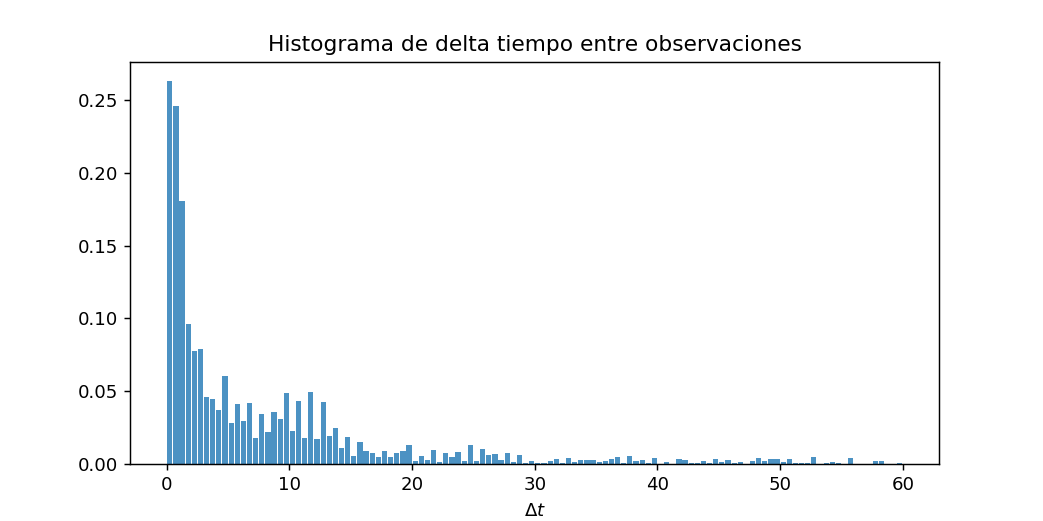

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
#for i in ['ECL','RRL','CEP']:
ax.hist(obs_all,bins=120,range=(0,60),density=True,alpha=0.8,rwidth=0.85)
    #display(i, obs_mean[i],obs_std[i])
ax.set_title('Histograma de delta tiempo entre observaciones')
ax.set_xlabel('$\Delta t$')
#ax.legend()
plt.show()

In [164]:
VVV2.__len__()

88454

In [82]:
n = int(VVV[3422]['data'][:,4].numpy().sum())
valid = np.sort(VVV[3422]['data'][:,3].numpy()[:n])
diffs = np.diff(valid)
display(valid,diffs, diffs.mean(),diffs.std())

array([0.00000000e+00, 8.87124002e-01, 7.07959518e+01, 7.37870331e+01,
       7.57570724e+01, 3.83942902e+02, 3.96835999e+02, 3.98883636e+02,
       4.13839630e+02, 4.19845093e+02, 4.35795776e+02, 5.96089600e+02,
       5.98154663e+02, 6.32055603e+02, 6.67163269e+02, 6.73030334e+02,
       6.73975952e+02, 6.86849792e+02, 6.90881104e+02, 6.96894043e+02,
       7.01967285e+02, 7.10939209e+02, 7.10962036e+02, 7.12827087e+02,
       7.14768494e+02, 7.22002014e+02, 7.36880676e+02, 7.37932190e+02,
       7.55900391e+02, 7.64893677e+02, 7.68774231e+02, 7.78812805e+02,
       7.83835388e+02, 7.90802979e+02, 8.02780945e+02, 8.03769836e+02,
       9.53081055e+02, 9.54141785e+02, 1.02318445e+03, 1.04711536e+03,
       1.09674365e+03, 1.13285486e+03, 1.13386963e+03, 1.15582043e+03,
       1.16281079e+03, 1.16879944e+03, 1.17876965e+03, 1.30911182e+03,
       1.31307605e+03, 1.32112610e+03, 1.32412097e+03, 1.37614258e+03,
       1.37704785e+03, 1.38118640e+03, 1.38695435e+03, 1.39004663e+03,
      

array([8.8712400e-01, 6.9908829e+01, 2.9910812e+00, 1.9700394e+00,
       3.0818582e+02, 1.2893097e+01, 2.0476379e+00, 1.4955994e+01,
       6.0054626e+00, 1.5950684e+01, 1.6029382e+02, 2.0650635e+00,
       3.3900940e+01, 3.5107666e+01, 5.8670654e+00, 9.4561768e-01,
       1.2873840e+01, 4.0313110e+00, 6.0129395e+00, 5.0732422e+00,
       8.9719238e+00, 2.2827148e-02, 1.8650513e+00, 1.9414062e+00,
       7.2335205e+00, 1.4878662e+01, 1.0515137e+00, 1.7968201e+01,
       8.9932861e+00, 3.8805542e+00, 1.0038574e+01, 5.0225830e+00,
       6.9675903e+00, 1.1977966e+01, 9.8889160e-01, 1.4931122e+02,
       1.0607300e+00, 6.9042664e+01, 2.3930908e+01, 4.9628296e+01,
       3.6111206e+01, 1.0147705e+00, 2.1950806e+01, 6.9903564e+00,
       5.9886475e+00, 9.9702148e+00, 1.3034216e+02, 3.9642334e+00,
       8.0500488e+00, 2.9948730e+00, 5.2021606e+01, 9.0527344e-01,
       4.1385498e+00, 5.7679443e+00, 3.0922852e+00, 1.4078735e+01,
       1.7236328e+00, 1.0324707e+00, 9.7436523e-01, 7.2736816e

24.101227

52.249493

In [43]:
VVV[JxECC[0][1]]['label'].item()

1

<IPython.core.display.Javascript object>


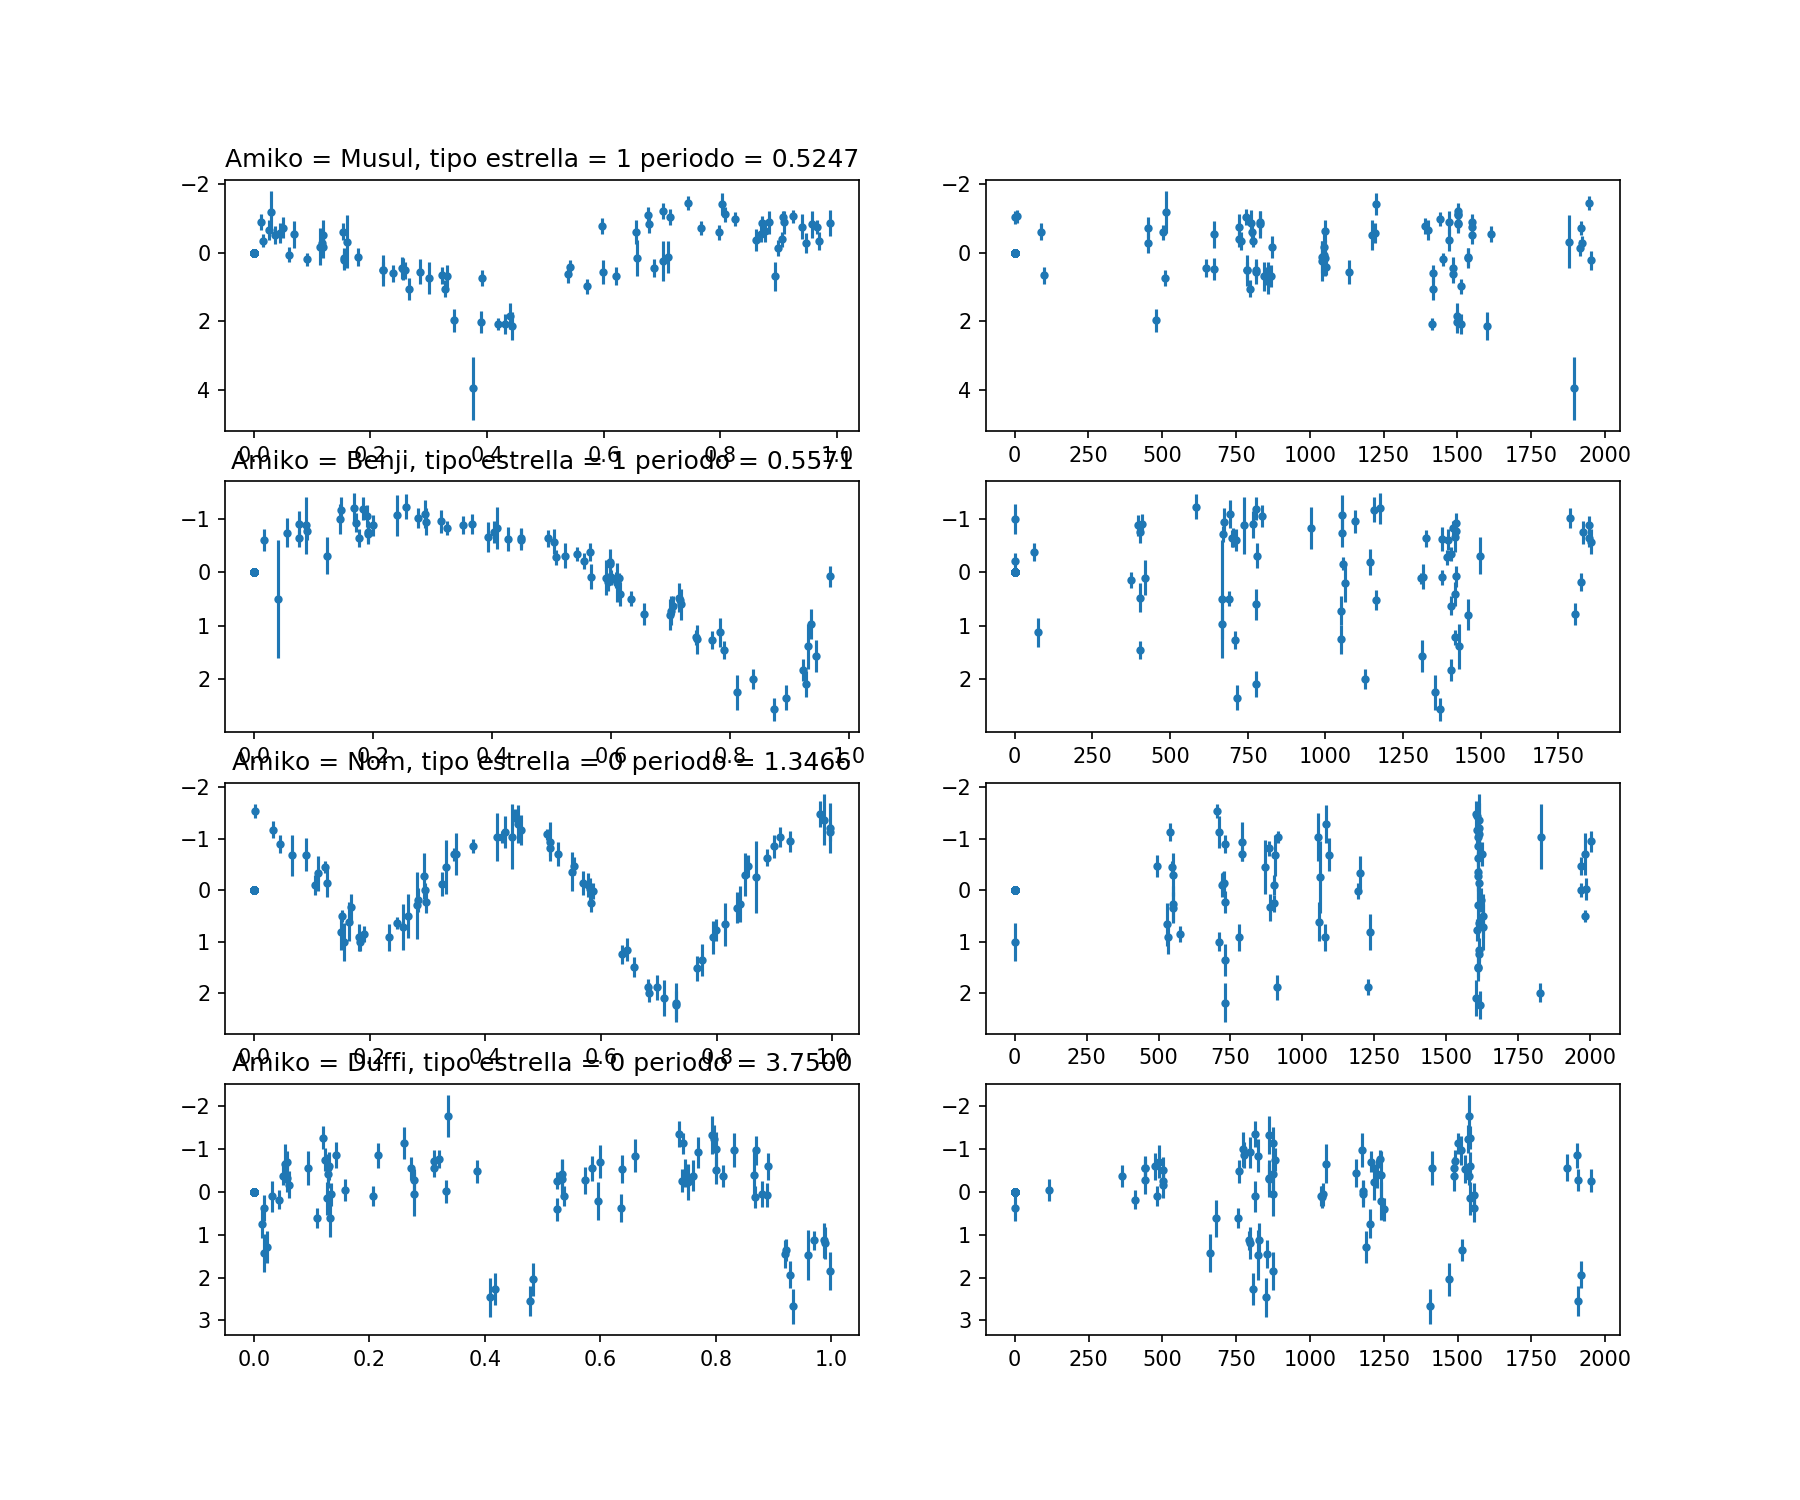

['Musul', 69420]
Amiko =  Musul
###################################################

['Benji', 70490]
Amiko =  Benji
###################################################

['Nom', 8888]
Amiko =  Nom
###################################################

['Duffi', 20001]
Amiko =  Duffi
###################################################



In [51]:
# JxECC
# lc_classes = {"label":{"binary":0, "rrlyrae":1, "cepheid":2}}
fig,ax=plt.subplots(4,2, figsize=(12,10), sharey=False)
JxECC = [['Musul',69420], ['Benji',70490], ['Nom',8888], ['Duffi',20001]]
for i,amiko in enumerate(JxECC):
    print(amiko)
    #print("###################################################\n")
    print("Amiko = ", amiko[0])
    ax[i][0].cla()  
    ax[i][0].errorbar(VVV[amiko[1]]['data'][:,0], VVV[amiko[1]]['data'][:, 1], VVV[amiko[1]]['data'][:, 2], fmt='.')
    ax[i][0].invert_yaxis()
    ax[i][1].cla()
    ax[i][1].errorbar(VVV[amiko[1]]['data'][:, 3], VVV[amiko[1]]['data'][:, 1], VVV[amiko[1]]['data'][:, 2], fmt='.')
    ax[i][1].invert_yaxis()
    print("###################################################\n")
    ax[i][0].set_title("Amiko = %s, tipo estrella = %d periodo = %0.4f" %(amiko[0],VVV[amiko[1]]['label'].item() ,VVV.period[amiko[1]]))

<IPython.core.display.Javascript object>


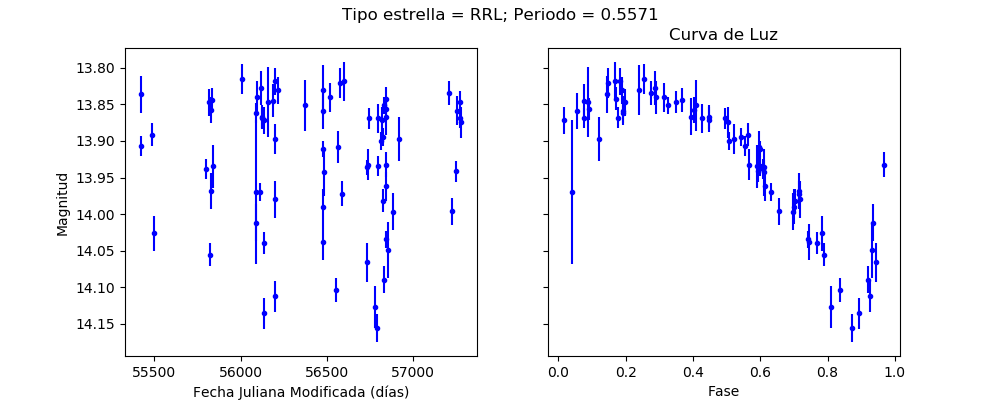

Text(0.5, 0.98, 'Tipo estrella = RRL; Periodo = 0.5571')

In [167]:

fig,ax=plt.subplots(1,2, figsize=(10,4),sharey=True)
n_star = 70490
ax[1].cla()
ax[1].errorbar(VVV2[n_star]['data'][:,0], VVV2[n_star]['data'][:, 1], VVV2[n_star]['data'][:, 2], fmt='b.')
ax[1].invert_yaxis()
ax[0].cla()
ax[0].errorbar(VVV2[n_star]['data'][:, 3], VVV2[n_star]['data'][:, 1], VVV2[n_star]['data'][:, 2], fmt='b.')
ax[0].invert_yaxis()
#print("###################################################\n")
#ax[0].set_title("Modified Julian Date")
ax[1].set_title("Curva de Luz")
ax[0].set_xlabel("Fecha Juliana Modificada (días)")
ax[0].set_ylabel("Magnitud")
ax[1].set_xlabel("Fase")
fig.suptitle("Tipo estrella = RRL; Periodo = %0.4f" % VVV2.period[n_star])

In [ ]:
lc_max=0
lc_min=np.inf
for i in VVV:
    if len(i['data'])>lc_max:
        lc_max=len(i['data'])
    if len(i['data'])<lc_min:
        lc_min=len(i['data'])
print(lc_min,lc_max)

In [19]:
VVV[420]['data'].shape

torch.Size([335, 5])

In [ ]:
VVV[420]['data'][:,0]

In [ ]:
#phase = VVV[i]['data'][:,0]
#mag = VVV[i]['data'][:,1]
#err = VVV[i]['data'][:,2]
#mask = VVV[i]['data'][:,4]
#label = VVV[i]['label'].item()
    # 0: Binary
    # 1: RRL
    # 2: Cepheid

In [52]:
VVV_len = Counter(VVV[:]['label'].numpy())

NameError: name 'Counter' is not defined

In [53]:
n_Bin = (VVV[:]['label'].numpy() == 0).sum()
n_RRL = (VVV[:]['label'].numpy() == 1).sum()
n_Cep = (VVV[:]['label'].numpy() == 2).sum()
VVV_len = np.array([n_Bin, n_RRL, n_Cep])
VVV_len

array([67873, 19087,  1494])

Generar Sampleo Random Manual Equitativo (EMRS)

In [21]:
class equal_manually_random(Dataset):    
    def __init__(self, data, targets,transform=None):
        assert torch.is_tensor(data)==True and torch.is_tensor(targets)==True
        self.data=data
        self.labels=targets
        self.transform=transform
    
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.data)

In [22]:
def MRS_dataset(rs):
    # Sampleo Random Manual NoEquitativo (NEMRS)
    less_lc = VVV_len.min()
    VVV_toy = list()
    ant=0
    for i,n_lc in enumerate(VVV_len):
        if i==0:
            rand_ind = np.random.permutation(np.arange(n_lc))[:less_lc*3]+ant
        elif i==1:
            rand_ind = np.random.permutation(np.arange(n_lc))[:less_lc*2]+ant
        elif i==2:
            rand_ind = np.random.permutation(np.arange(n_lc))[:less_lc]+ant
        VVV_toy.append(rand_ind)
        ant += n_lc
    VVV_sameRandInd = np.concatenate(VVV_toy)
    # Data filter
    targets = [VVV[i]['label'].item() for i in VVV_sameRandInd]
    targets = torch.tensor(targets,dtype=torch.long)
    LC_magData = [VVV[i]['data'][:,1].numpy() for i in VVV_sameRandInd]
    LC_errData = [VVV[i]['data'][:,2].numpy() for i in VVV_sameRandInd]
    LC_mask = [VVV[i]['data'][:,4].numpy() for i in VVV_sameRandInd]
    LC_magData = torch.tensor(LC_magData)
    LC_errData = torch.tensor(LC_errData)
    LC_mask = torch.tensor(LC_mask)
    mag_err_mask=torch.stack((LC_magData,LC_errData,LC_mask),dim=1)
    # Dataset
    VVV_equalDataset = equal_manually_random(mag_err_mask, targets)
    return VVV_equalDataset

### Dataloaders

In [12]:
train_test_idx, valid_idx = get_train_test_ids(df_meta,test_size=0.1)
# usar valid_idx sólo para validar, matriz de confusion final

# pasamos de tipo Int64Index a int32
train_test_idx, valid_idx = np.array(train_test_idx,dtype='int32'), np.array(valid_idx, dtype='int32')

# slice por iloc del df_meta
df_train = df_meta.iloc[train_test_idx]
# sub dividir train_test_idx para train y test (un 20%)
train_idx, test_idx = get_train_test_ids(df_train, test_size=0.2)

In [13]:
from collections import Counter

display(Counter(list(df_meta.loc[train_idx]["label"])))
display(Counter(list(df_meta.loc[test_idx]["label"])))
display(Counter(list(df_meta.loc[valid_idx]["label"])))

Counter({0: 48868, 1: 13742, 2: 1076})

Counter({0: 12217, 1: 3436, 2: 269})

Counter({0: 6788, 1: 1909, 2: 149})

In [14]:
def make_dataloaders(dataset,use_IDS,split,train_size=32,test_size=64):
    global train_idx
    global test_idx
    if use_IDS:
        # ImbalancedDatasetSampler
        #train_idx, valid_idx= train_test_split(
        #                                np.arange(len(dataset)),
        #                                test_size=split,
        #                                shuffle=True,
        #                                stratify=dataset[:]['label'])
        #train_idx, valid_idx = list(train_idx), list(valid_idx)
        train_loader = DataLoader(dataset,
                          sampler=ImbalancedDatasetSampler(dataset,
                                                           indices=train_idx,
                                                           callback_get_label= lambda dataset, idx:dataset[idx]['label'].item()),
                          batch_size=train_size, shuffle=False)

        test_loader= DataLoader(dataset,
                                sampler=SubsetRandomSampler(test_idx),
                                batch_size=test_size, shuffle=False)
    else:
        """
        train_idx, valid_idx= train_test_split(
                                        np.arange(len(dataset)),
                                        test_size=split,
                                        shuffle=True,
                                        stratify=None)
        """
        train_idx, test_idx = list(train_idx), list(test_idx)
        train_loader = DataLoader(dataset,
                                sampler=SubsetRandomSampler(train_idx),
                                batch_size=train_size, shuffle=False)

        test_loader = DataLoader(dataset,
                                sampler=SubsetRandomSampler(test_idx),
                                batch_size=test_size, shuffle=False)
    return train_loader, test_loader

### Def. Modelo NN

In [270]:
# implementacion adaptada a 1D de https://github.com/naoto0804/pytorch-inpainting-with-partial-conv

class PartialConv(nn.Module):
    def __init__(self, in_channels_C,in_channels_M, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.input_conv = nn.Conv1d(in_channels_C, out_channels, kernel_size,
                                    stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv1d(in_channels_M, out_channels, kernel_size,
                                   stride, padding, dilation, groups, False)
        # self.input_conv.apply(weights_init('kaiming'))

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self,input, mask):
        # http://masc.cs.gmu.edu/wiki/partialconv
        # C(X) = W^T * X + b, C(0) = b, D(M) = 1 * M + 0 = sum(M)
        # W^T* (M .* X) / sum(M) + b = [C(M .* X) – C(0)] / D(M) + C(0)
        #print(input.shape, mask.shape)
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        no_update_holes = output_mask == 0
        mask_sum = output_mask.masked_fill_(no_update_holes, 1.0)

        output_pre = (output - output_bias) / mask_sum + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)

        new_mask = torch.ones_like(output)
        new_mask = new_mask.masked_fill_(no_update_holes, 0.0)

        return output, new_mask

In [271]:
class MLP_last(torch.nn.Module):
    def __init__(self, in_channels_C=2,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=3): 
        super(MLP_last, self).__init__()
        self.pconv1 = PartialConv(in_channels_C,in_channels_M, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = PartialConv(c4, c4, c2, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
        #                                 ceil_mode=False, count_include_pad=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(1)
        
        self.hidden1 = torch.nn.Linear(c2*1, hid_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=True)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x,mask, t=0):
        if t==1:
            x = x.transpose(0,1)
            mask = mask.transpose(0,1)
        elif t==2:
            #x = x.transpose(1,2)
            mask = mask.transpose(1,2)
    
        x, mask = self.pconv1(x, mask)
        x = self.activation(x)
        x, mask = self.pconv2(x, mask)
        x = self.activation(x)
        x, mask = self.pconv3(x, mask)
        x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        z = self.gap(x)
        z = z.reshape(-1,64*1)
        z = self.activation(self.hidden1(z))
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        fuera = self.output(z)
        return fuera



In [45]:
class MLP_last2(torch.nn.Module):
    def __init__(self, in_channels_C=1,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=3): 
        super(MLP_last2, self).__init__()
        self.pconv1 = PartialConv(in_channels_C,in_channels_M, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = PartialConv(c4, c4, c2, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
        #                                 ceil_mode=False, count_include_pad=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(1)
        
        self.hidden1 = torch.nn.Linear(c2*1, hid_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=True)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x,mask, t=0):
        if t==1:
            x = x.transpose(0,1)
            mask = mask.transpose(0,1)
        elif t==2:
            #x = x.transpose(1,2)
            mask = mask.transpose(1,2)
    
        x, mask = self.pconv1(x, mask)
        x = self.activation(x)
        x, mask = self.pconv2(x, mask)
        x = self.activation(x)
        x, mask = self.pconv3(x, mask)
        x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        z = self.gap(x)
        z = z.reshape(-1,64*1)
        z = self.activation(self.hidden1(z))
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        fuera = self.output(z)
        return fuera



In [15]:
class MLP_last3(torch.nn.Module):
    def __init__(self, in_channels_C=1,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=3): 
        super(MLP_last3, self).__init__()
        self.pconv1 = nn.Conv1d(in_channels_C, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = nn.Conv1d(c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = nn.Conv1d(c4, c2, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
        #                                 ceil_mode=False, count_include_pad=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(1)
        
        self.hidden1 = torch.nn.Linear(c2*1, hid_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=True)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x, t=0):
        if t==1:
            x = x.transpose(0,1)
            #mask = mask.transpose(0,1)
        elif t==2:
            x = x.transpose(1,2)
            #mask = mask.transpose(1,2)
    
        #x, mask = self.pconv1(x, mask)
        x = self.pconv1(x)
        x = self.activation(x)
        #x, mask = self.pconv2(x, mask)
        x = self.pconv2(x)
        x = self.activation(x)
        #x, mask = self.pconv3(x, mask)
        x = self.pconv3(x)
        x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        z = self.gap(x)
        z = z.reshape(-1,64*1)
        z = self.activation(self.hidden1(z))
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        fuera = self.output(z)
        return fuera



In [58]:
class MLP_gap(torch.nn.Module):
    def __init__(self, in_channels_C=2,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=5): 
        super(MLP_gap, self).__init__()
        self.pconv1 = PartialConv(in_channels_C,in_channels_M, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = PartialConv(c4, c4, c2, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
        #                                 ceil_mode=False, count_include_pad=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(1)
        
        self.hidden1 = torch.nn.Linear(c2*1, hid_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=True)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x,mask, t=0):
        if t==1:
            x = x.transpose(0,1)
            mask = mask.transpose(0,1)
        elif t==2:
            #x = x.transpose(1,2)
            mask = mask.transpose(1,2)
    
        x, mask = self.pconv1(x, mask)
        x = self.activation(x)
        x, mask = self.pconv2(x, mask)
        x = self.activation(x)
        x, mask = self.pconv3(x, mask)
        x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        z = self.gap(x)
        z = z.reshape(-1,64*1)
        z = self.activation(self.hidden1(z))
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        fuera = self.output(z)
        return fuera


In [18]:
modelo = MLP_last()
display(modelo)

MLP_last(
  (pconv1): PartialConv(
    (input_conv): Conv1d(2, 16, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(1, 16, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(16, 16, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(16, 16, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv3): PartialConv(
    (input_conv): Conv1d(16, 64, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(16, 64, kernel_size=(3,), stride=(2,), bias=False)
  )
  (gap): AdaptiveMaxPool1d(output_size=1)
  (hidden1): Linear(in_features=64, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
  (activation): ReLU()
)

In [24]:
total_params = sum(p.numel() for p in modelo.parameters() if p.requires_grad)
total_params

6691

#### BetaTesting-b4-Train

**Check GPU**

In [16]:
cuda.is_available()

True

In [17]:
torch.cuda.current_device()

0

In [17]:
torch.cuda.set_device('cuda:0')

### ENTRENAMIENTO

In [18]:
n_model = '03'
path_models = '/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/models/'
path_results = '/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/results/'
model_name = 'LCC_newDataset_model_'+n_model+'_'
path = path_models+model_name

Path nombre modelo
**LCC_newDataset_model_0x_sample_n**
- 01:
    - Data: magnitud, error
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='weighted'
    - IDS: True
  
- 02:
    - Data: Magnitud
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='micro'
    - IDS: True

- 03:
    - Data: Magnitud
    - Mask: False
    - Concolution: 1D (usual)
    - f1_acum average='macro'
    - IDS: True

- 04:
    - Data: magnitud, error
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='MACRO'
    - IDS: True

- 04b (just sample0):
    - Data: magnitud, error
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='MACRO'
    - IDS: FALSE
 
- 04c (same 4b but less epochs and patience):
    - Data: magnitud, error
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='MACRO'
    - IDS: FALSE
 
- 04d (same 4c but IDS true):
    - Data: magnitud, error
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='MACRO'
    - IDS: True
    
- 05:
    - Data (canales): magnitud, error y "máscara"
    - mask: False
    - Convolution: 1D (usual)
    -

- 06: Introducir Periodo a la última y algunas features "clásicas" (al mejor modelo de ConvParcial)

- 07: Entrenar sin Zero-Padding
    - Batch tamaño 1
    - convolucional 1D

In [19]:
def update_plot(ax,TL,VL,F1,last_ep_f1,best_f1,topf1_logs):
    #global comentario
    titulo="Current Training:"+' '+model_name+" Sample="+str(s)
    [ax_.cla() for ax_ in ax]
    # plot 0 : TL, VL, last_ep
    ax[0].plot(range(len(TL)), TL, lw=2, label='Train Loss')
    ax[0].plot(range(len(VL)), VL, lw=2, label='Valid Loss')
    #ax[0].axvline(last_ep_vl,c='r',marker='|',lw=1,label="Last improve")
    #ax[1].plot(range(len(F1)),np.full_like(F1,max(F1)),'r--',lw=1, label='best F1')
    # plot 1 : F1, topf1_logs
    ax[1].plot(range(len(F1)), F1, lw=2, label='F1 score')
    label_epoch = "Last improve "+str(last_ep_f1)
    ax[1].axvline(last_ep_f1,c='r',marker='|',lw=1,label=label_epoch)
    if len(topf1_logs)==0:
        # plot topf1 actual
        label_f1 = 'top F1 actual '+str('%.3f'%(max(F1)))
        ax[1].plot(range(len(F1)),np.full_like(F1,max(F1)),'r--',lw=1, label=label_f1)
        
    else:
        # plot topf1 mean
        # revisar ultima epoca subida f1
        label_f1 = 'top F1 '+str('%.3f'%(best_f1))
        ax[1].plot(range(len(F1)),np.full_like(F1,best_f1),'r--',lw=1, label=label_f1)
        ax[1].plot(range(len(F1)),np.full_like(F1,np.mean(topf1_logs)),'g--',lw=1, label='mean F1 hist')
    [ax_.set_xlabel('Epochs') for ax_ in ax]
    [ax_.grid() for ax_ in ax]
    [ax_.legend() for ax_ in ax]
    fig.suptitle(titulo)
    fig.canvas.draw()
    fig.canvas.flush_events()

In [ ]:
#phase = VVV[i]['data'][:,0]
#mag = VVV[i]['data'][:,1]
#err = VVV[i]['data'][:,2]
#mask = VVV[i]['data'][:,4]
#label = VVV[i]['label'].item()
    # 0: Binary
    # 1: RRL
    # 2: Cepheid

In [262]:
# MODELO [01,04], 2 canales(mag,err), Mask
# ajustes a condiciones de término de entrenamiento y guardado
def training(modelo, criterion, lr,wd, epochs, use_gpu, train_loader, test_loader,path_full,ax,topf1_logs):
    optimizer = torch.optim.Adam(modelo.parameters(), lr=lr,weight_decay=wd)
    #ultima_mejora --> VL, 
    # ambas por época (no cambian juntas)
    #ultima_mejora = 0
    paciencia = 50
    ultima_subida_f1 = 0
    best_valid,best_f1= np.inf,0.0
    # Historiales por épocas
    TL,VL,F1=list(),list(),list()

    for k in tqdm(epochs):
        if (k-ultima_subida_f1 >= paciencia):
            print("Hace al menos ", paciencia," épocas NO aumenta F1 Score macro. Best F1=",best_f1)
            # guardar plot 
            # plt.savefig(PATH)
            break
        
        train_loss, valid_loss,f1_acum = 0.0, 0.0, 0.0
        # Loop de entrenamiento
        for batch in train_loader:
            
            inputs, labels = batch['data'],batch['label']
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            #break
            data,mask = inputs[:,[1,2]],inputs[:,4].unsqueeze(0).transpose(0,1)
            #display(data.shape,mask.shape)
            #display(data,mask)
            optimizer.zero_grad()
            outputs = modelo.forward(data,mask,t=0)
            #display(outputs.shape,labels.shape)
            #break
            loss = criterion(outputs,labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        TL.append(train_loss/train_loader.__len__()) 

        # VALIDACION 
        for batch in test_loader:
            #actual_f1 = f1_acum/test_loader.__len__()
            inputs, labels = batch['data'],batch['label']
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            data,mask = inputs[:,[1,2]],inputs[:,4].unsqueeze(0).transpose(0,1)
            
            y_true=labels.cpu().numpy()
            #display(y_true)
            #break
            outputs = modelo.forward(data,mask,t=0)
            # F1 score
            y_pred=outputs.cpu().detach().argmax(dim=1).numpy()
            #print(y_pred)
             # cambio 'weighted' por 'macro' (seguro? no será 'micro'?)
            f1_acum += f1_score(y_true, y_pred, average='macro')
            loss = criterion(outputs,labels)
            #print(loss.item())
            valid_loss += loss.item()
            #print(valid_loss)
            # save best model
        # usar F1 como condición para guardar
        f1_last = f1_acum/test_loader.__len__()
        valid_loss_last = valid_loss/test_loader.__len__()
        if f1_last > best_f1:
            ultima_subida_f1 = k
            #print("vamos mejorando :) epoch=",k+1)
            #best_valid = valid_loss
            best_f1 = f1_last
            torch.save({'epoca': k,
                        'f1_score': best_f1,
                        'model_state_dict': modelo.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'Valid_loss': valid_loss_last}, path_full)
        VL.append(valid_loss_last)
        F1.append(f1_last)
        update_plot(ax,TL,VL,F1,ultima_subida_f1,best_f1,topf1_logs)

    # Retornar modelo a la CPU
    if use_gpu:
        modelo = modelo.cpu()
        #print("ok")
    return best_f1

In [ ]:
# MODELO 02, 1 canal (mag), Mask
def training(modelo, criterion, lr,wd, epochs, use_gpu, train_loader, test_loader,path_full,ax,topf1_logs):
    optimizer = torch.optim.Adam(modelo.parameters(), lr=lr,weight_decay=wd)
    ultima_mejora = 0
    best_valid,best_f1_= np.inf,0.0
    TL,VL,F1=list(),list(),list()

    for k in tqdm(epochs):
        if k-ultima_mejora >=300:
            print("Hace al menos 300 épocas NO disminuye Valid Loss. Best F1=",best_f1)
            break
        train_loss, valid_loss,f1_acum = 0.0, 0.0, 0.0
        # Loop de entrenamiento
        for batch in train_loader:
            inputs, labels = batch['data'],batch['label']
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            data,mask = inputs[:,1].unsqueeze(0).transpose(0,1),inputs[:,4].unsqueeze(0).transpose(0,1)
            #display(data.shape,mask.shape)
            #display(data,mask)
            optimizer.zero_grad()
            outputs = modelo.forward(data,mask,t=0)
            #display(outputs.shape,labels.shape)
            #break
            loss = criterion(outputs,labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        TL.append(train_loss/train_loader.__len__()) 
        #break
        # VALIDACION 
        for batch in test_loader:
            inputs, labels = batch['data'],batch['label']
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            data,mask = inputs[:,1].unsqueeze(0).transpose(0,1),inputs[:,4].unsqueeze(0).transpose(0,1)
    
            y_true=labels.cpu().numpy()
            #display(y_true)
            #break
            outputs = modelo.forward(data,mask,t=0)
            # F1 score
            y_pred=outputs.cpu().detach().argmax(dim=1).numpy()
            #print(y_pred)
             # cambio 'weighted' por 'macro'
            f1_acum += f1_score(y_true, y_pred, average='macro')
            loss = criterion(outputs,labels)
            #print(loss.item())
            valid_loss += loss.item()
            #print(valid_loss)
            # save best model
        # usar F1 como condición para guardar
        if valid_loss < best_valid:
            ultima_mejora = k+1
            #print("vamos mejorando :) epoch=",k+1)
            best_valid = valid_loss
            best_f1 = f1_acum/test_loader.__len__()
            torch.save({'epoca': k,
                        'f1_score': best_f1,
                        'model_state_dict': modelo.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'Valid_loss': valid_loss/test_loader.__len__()}, path_full)
        VL.append(valid_loss/test_loader.__len__())
        F1.append(f1_acum/test_loader.__len__())
        update_plot(ax,TL,VL,F1,ultima_mejora,best_f1,topf1_logs)

    # Retornar modelo a la CPU
    if use_gpu:
        modelo = modelo.cpu()
        #print("ok")
    return best_f1

In [40]:
# MODELO 03, 1 canal (mag), Mask
def training(modelo, criterion, lr,wd, epochs, use_gpu, train_loader, test_loader,path_full,path_save,ax,topf1_logs):
    optimizer = torch.optim.Adam(modelo.parameters(), lr=lr,weight_decay=wd)
    paciencia = 50
    ultima_subida_f1 = 0
    best_valid,best_f1= np.inf,0.0
    # Historiales por épocas
    TL,VL,F1=list(),list(),list()

    for k in tqdm(epochs):
        if (k-ultima_subida_f1 >= paciencia):
            print("Hace al menos ", paciencia," épocas NO aumenta F1 Score macro. Best F1=",best_f1)
            # guardar plot 
            plt.savefig(path_save)
            break
        train_loss, valid_loss,f1_acum = 0.0, 0.0, 0.0
        # Loop de entrenamiento
        for batch in train_loader:
            inputs, labels = batch['data'],batch['label']
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            #data,mask = inputs[:,1].unsqueeze(0).transpose(0,1),inputs[:,4].unsqueeze(0).transpose(0,1)
            data = inputs[:,1].unsqueeze(0).transpose(0,1)
            #display(data.shape)
            #display(data)
            data = data.type(torch.cuda.FloatTensor)
            optimizer.zero_grad()
            outputs = modelo.forward(data,t=0)
            #display(outputs.shape,labels.shape)
            #break
            loss = criterion(outputs,labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        TL.append(train_loss/train_loader.__len__()) 
        #break
        # VALIDACION 
        for batch in test_loader:
            inputs, labels = batch['data'],batch['label']
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            #data,mask = inputs[:,1].unsqueeze(0).transpose(0,1),inputs[:,4].unsqueeze(0).transpose(0,1)
            data = inputs[:,1].unsqueeze(0).transpose(0,1)
            y_true=labels.cpu().numpy()
            #display(y_true)
            #break
            data = data.type(torch.cuda.FloatTensor)
            outputs = modelo.forward(data,t=0)
            # F1 score
            y_pred=outputs.cpu().detach().argmax(dim=1).numpy()
            #print(y_pred)
             # cambio 'weighted' por 'macro'
            f1_acum += f1_score(y_true, y_pred, average='macro')
            loss = criterion(outputs,labels)
            #print(loss.item())
            valid_loss += loss.item()
            #print(valid_loss)
            # save best model
        # usar F1 como condición para guardar
        f1_last = f1_acum/test_loader.__len__()
        valid_loss_last = valid_loss/test_loader.__len__()
        if f1_last > best_f1:
            ultima_subida_f1 = k
            #print("vamos mejorando :) epoch=",k+1)
            #best_valid = valid_loss
            best_f1 = f1_last
            torch.save({'epoca': k,
                        'f1_score': best_f1,
                        'model_state_dict': modelo.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'Valid_loss': valid_loss_last}, path_full)
        VL.append(valid_loss_last)
        F1.append(f1_last)
        update_plot(ax,TL,VL,F1,ultima_subida_f1,best_f1,topf1_logs)

    # Retornar modelo a la CPU
    if use_gpu:
        modelo = modelo.cpu()
        #print("ok")
    return best_f1

In [42]:
# Parametros generales
n_epochs=1000
lr=0.0002
wd = 0
epochs = range(n_epochs)
use_gpu = True
use_IDS = True
criterion = torch.nn.CrossEntropyLoss()
semilla=774892200
rs=RandomState(semilla)
split,train_size,test_size=0.3,1,1

<IPython.core.display.Javascript object>


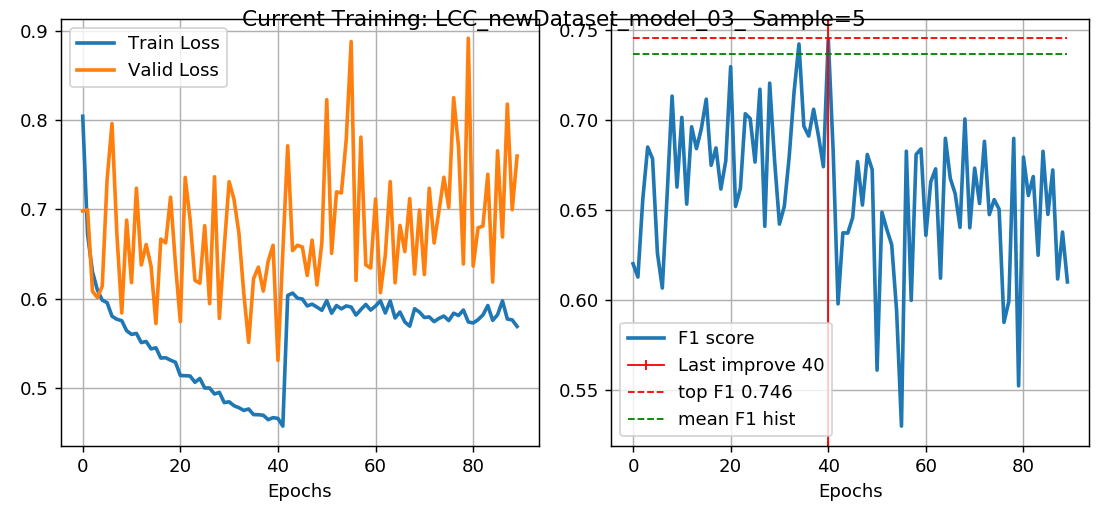


Begin Training new Dataset


Hace al menos  50  épocas NO aumenta F1 Score macro. Best F1= 0.7370305238035423


Hace al menos  50  épocas NO aumenta F1 Score macro. Best F1= 0.7370933299836704


Hace al menos  50  épocas NO aumenta F1 Score macro. Best F1= 0.7456349704810954
Results: F1-Score-Macro mean= 0.739919608089436 F1-Score-Macro std= 0.004041452841496593
End Training new Dataset
-------END-------


In [43]:
# New Dataset (Jun 2020)
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4), tight_layout=True, sharex=True)
top5f1=list()
prompt="Training new Dataset"
print("\nBegin",prompt)
for s in [3,4,5]: 
    comentario = "sample_"+str(s)
    path_full = path+comentario+'.pt'
    path_save = path_results+model_name+comentario+'.png'
    # DataLoaders
    train_loader, test_loader = make_dataloaders(VVV2,use_IDS,split,train_size,test_size)
    # ENTRENAR
    modelo=MLP_last3()
    if use_gpu:
        modelo=modelo.cuda()
    topf1 = training(modelo, criterion, lr,wd, epochs, use_gpu, train_loader, test_loader,path_full,path_save,ax,top5f1)
    top5f1.append(topf1)

# return f1 mean, f1 std
print("Results: F1-Score-Macro mean=",np.mean(top5f1),"F1-Score-Macro std=",np.std(top5f1))
print("End",prompt)
print("-------END-------")

In [ ]:
# original práctica (Ene-Feb 2020)
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4), tight_layout=True, sharex=True)
# for IDS in [0,1]:
for rot_key in [0,1]:
    for alpha in [0,0.25,0.5,0.75,1]:
        top5f1=list()
        prompt="Training. Rot="+str(rot_key)+", Alpha="+str(alpha)
        print("\nBegin",prompt)
        for s in range(5): 
            comentario = "_Rot"+str(rot_key)+"_Alpha"+str(alpha)+"_sampleo"+str(s)
            path = '/home/amorales/models/best_LCC_model_last_'+comentario+'.pt'
            # sampleo random manual y crear dataset
            VVV_eqData=MRS_dataset(rs)
            # DataLoaders
            train_loader, test_loader = make_dataloaders(VVV_eqData,use_IDS,split,train_size,test_size)
            # ENTRENAR
            modelo=MLP_last()
            if use_gpu:
                modelo=modelo.cuda()
            topf1 = training(modelo, criterion, lr,wd, epochs, use_gpu, train_loader, test_loader,path,ax,top5f1)
            top5f1.append(topf1)
        
        # return f1 mean, f1 std
        print("Results: F1 mean=",np.mean(top5f1),"F1 std=",np.std(top5f1))
        print("End",prompt)
print("-------END-------")

**Matriz de Confusión**

In [ ]:
# (Ene-Feb 2020)
besto = MLP()
PATH = '/home/amorales/tesis/models/best_LCC_model_dataRot0_Alpha1_sampleo4.pt'
besto.load_state_dict(torch.load(PATH)['model_state_dict'])

In [44]:
n_model = '03'
#path = '/home/amorales/tesis/LC_test/models/LCC_newDataset_model_'+n_model+'_'
path = '/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/models/LCC_newDataset_model_'+n_model+'_'
comentario = "sample_"+str(0)
path_full = path+comentario+'.pt'

In [46]:
# (Jun 2020)
besto = MLP_last3()
#PATH = '/home/amorales/tesis/models/best_LCC_model_dataRot0_Alpha1_sampleo4.pt'
besto.load_state_dict(torch.load(path_full,map_location='cuda:0')['model_state_dict'])

RuntimeError: CUDA error: unspecified launch failure

In [293]:
valid_loader= DataLoader(VVV,
                         sampler=SubsetRandomSampler(valid_idx),
                         batch_size=64, shuffle=False)

In [294]:
# MODIFICADA New Dataset (Jun 2020)
#y_true = [best_of_best[i]['label'].item() for i in range(len(best_of_best))]
#y_true = [VVV[i]['label'].item() for i in valid_idx]

prediction_test = []
labels_test=[]
for batch in valid_loader:
    inputs, labels = batch['data'],batch['label']
    inputs = inputs.transpose(1,2)
    #display(inputs.shape,labels.shape)
    data,mask = inputs[:,[1,2]],inputs[:,4].unsqueeze(0).transpose(0,1)
    labels_test.append(labels.detach().numpy())
    #y_true=labels.cpu().numpy()
    #display(y_true)
    #break
    outputs = besto.forward(data,mask,t=0)
    # F1 score
    y_pred=outputs.detach().argmax(dim=1).numpy()
    #print(outputs)
    prediction_test.append(outputs.detach().argmax(dim=1).numpy())
y_true = np.concatenate(labels_test)
y_pred = np.concatenate(prediction_test)

<IPython.core.display.Javascript object>


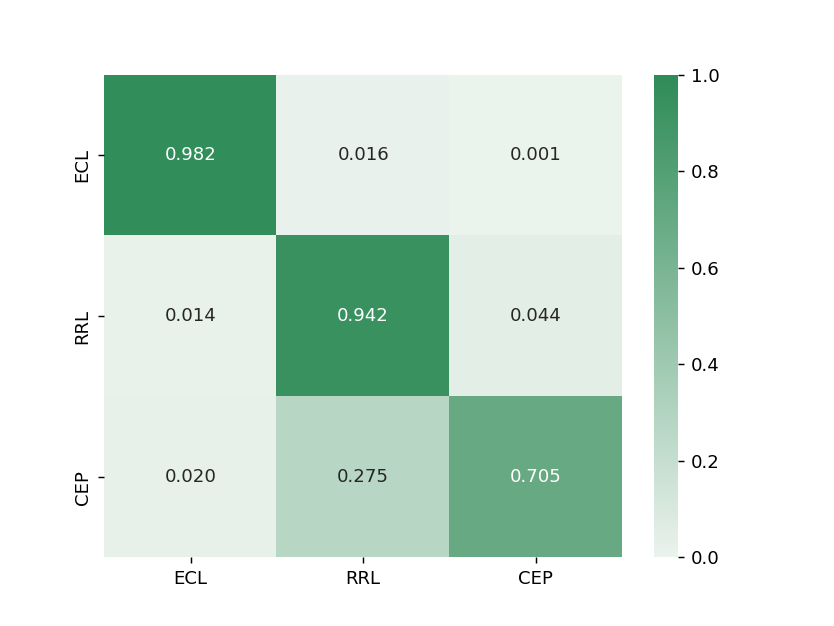

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6788
           1       0.92      0.94      0.93      1909
           2       0.53      0.70      0.60       149

    accuracy                           0.97      8846
   macro avg       0.82      0.88      0.84      8846
weighted avg       0.97      0.97      0.97      8846



In [295]:
#print(y_pred.__len__()/5)
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#display(cm)
stars = ['ECL','RRL','CEP']
df_cm = pd.DataFrame(cm, index=stars, columns=stars)
#cmap = sb.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sb.light_palette("seagreen", as_cmap=True)
sb.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0, fmt='.3f',cmap=cmap)
print(classification_report(y_true, y_pred))

In [ ]:
lc_classes = {"label":{"binary":0, "rrlyrae":1, "cepheid":2}}

In [ ]:
# Original (Ene-Feb 2020)
#y_true = [best_of_best[i]['label'].item() for i in range(len(best_of_best))]
#y_true = [VVV[i]['label'].item() for i in valid_idx]

prediction_test = []
labels_test=[]
for data in test_loader:
    inputs, labels = data['data'],data['label']
    data,mask = inputs[:,:2],inputs[:,2].unsqueeze(-1)
    labels_test.append(labels.detach().numpy())
    outputs = besto.forward(data,mask,t=2)
    #logits = modelo.forward(sample_data)
    #print(outputs)
    prediction_test.append(outputs.detach().argmax(dim=1).numpy())
y_true = np.concatenate(labels_test)
y_pred = np.concatenate(prediction_test)
print(y_pred.__len__()/5)
cm = confusion_matrix(y_true, y_pred)
display(cm)

print(classification_report(y_true, y_pred))

### Comparación entre distintos Modelos
Historial Matrices de Confusion [https://docs.google.com/spreadsheets/d/1j9kseGSx1WQvkb1C4nDL5J-lweuH3VyPsrAT50E1D6w/edit#gid=0]

In [ ]:
with open('lc_debug.pkl', 'rb') as handle:
    lc_debug = pickle.load(handle)

In [ ]:
path1= '/home/amorales/models/best_LCC_model_NoPool__Rot1_Alpha1_sampleo1.pt'
path0= '/home/amorales/models/best_LCC_model__Rot1_Alpha1_sampleo0.pt'

In [ ]:
besto0,besto1 = MLP_(),MLP()
#PATH = '/home/amorales/models/best_LCC_model_dataRot0_Alpha1_sampleo4.pt'
besto0.load_state_dict(torch.load(path0)['model_state_dict'])
besto1.load_state_dict(torch.load(path1)['model_state_dict'])

In [ ]:
pond=2.3
fig1, ax1 = plt.subplots(6, 4, figsize=(4*pond, 6*pond), tight_layout=True,sharey=True,sharex=False)
fig2, ax2 = plt.subplots(6, 4, figsize=(4*pond, 6*pond), tight_layout=True,sharey=True,sharex=True)
fig1.suptitle("Modelo sin Activacion")
fig2.suptitle("Modelo con Activacion, sin Pooling")
for i,lc in enumerate(lc_debug):
    data,label=lc['data'],lc['label']
    n = sum(data[:,4]==1).item()
    print(n)
    pha = data[:,0]
    mag = data[:,1]
    err = data[:,2]
    data2=torch.stack((mag,err))
    data,mask = data2.unsqueeze(0),data[:,4].unsqueeze(-1).unsqueeze(0).transpose(1,2)
    #data,mask = data[:,:2].unsqueeze(0).transpose(1,2),data[:,4].unsqueeze(0).unsqueeze(-1).transpose(1,2)
    norm = Normalize(0,1,clip=False)
    for j in range(4):
        if i<3:
            star="ECL"
        else:
            star="RRL"
        if j!=3:
            layer="Conv "+str(j+1)
        else:
            layer="GAP"
        if j==0:
            data0,mask0=besto0.pconv1(data,mask)
            data1,mask1=besto1.pconv1(data,mask)
            data1=besto1.activation(data1)

        elif j==1:
            data0,mask0=besto0.pconv2(data0,mask0)
            data1,mask1=besto1.pconv2(data1,mask1)
            data1=besto1.activation(data1)

        elif j==2:
            data0,mask0=besto0.pconv3(data0,mask0)
            data1,mask1=besto1.pconv3(data1,mask1)
            data1=besto1.activation(data1)

        else:       
            mask0_tmp=mask0.squeeze()[0].numpy().astype('int32')
            mask1_tmp=mask1.squeeze()[0].numpy().astype('int32')
            m0,m1= sum(mask0_tmp),sum(mask1_tmp)
            print(m0,m1)
            data0_tmp=data0.squeeze().detach()
            data1_tmp=data1.squeeze().detach()
            data0_slice=data0_tmp[:,:m0].unsqueeze(0)
            data1_slice=data1_tmp[:,:m1].unsqueeze(0)
            """mask0_tmp=mask0.bool()
            data0_slice=data0[mask0_tmp]
            mask1_tmp=mask1.bool()
            data1_slice=data1[mask1_tmp]
            display(mask1_tmp.shape,data1_slice.shape)"""
            data0=besto0.gap(data0_slice)
            data1=besto1.gap(data1_slice)
            display(data0.shape,data1.shape)
        #plot
        #ax1[i][j].errorbar(pha,mag,err, fmt='b.')
        #ax2[i][j].errorbar(pha,mag,err, fmt='b.')
        filtro0=data0.squeeze().detach().numpy()
        filtro1=data1.squeeze().detach().numpy()
        ax1[i][j].imshow(filtro0,norm=norm,cmap='plasma')
        ax2[i][j].imshow(filtro1,norm=None)
        ax1[i][j].set_title(star+" after "+layer+", n= "+str(n))
        ax2[i][j].set_title(star+" after "+layer+", n= "+str(n))
        if i==0 and j==0:
            ax1[i][j].invert_yaxis()
            ax2[i][j].invert_yaxis()

        

In [ ]:
torch.repeat_interleave?

In [ ]:
x = torch.tensor([[1,2,3],[4,5,6]])
y = torch.from_numpy(np.random.random(100))
y_rp = y.repeat_interleave(2,dim=0)
display(y,y_rp,y.shape,y_rp.shape)

In [ ]:
pond=2
#fig, ax = plt.subplots(4, 2, figsize=(4*pond, 6*pond), tight_layout=False)
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4), tight_layout=True, sharex=False)
data=lc_debug[1]['data']
n = sum(data[:,4]==1).item()
print(n)
mag = data[:,1]
err = data[:,2]
data2=torch.stack((mag,err))
data,mask = data2.unsqueeze(0),data[:,4].unsqueeze(-1).unsqueeze(0).transpose(1,2)
data1,mask1=besto0.pconv1(data,mask)
mask_tmp=mask1.squeeze()[0].numpy().astype('int32')
m= sum(mask_tmp)
print(m)
data_tmp=data1.squeeze().detach()
data_slice=data_tmp[:,:m]
data_repeat=data_slice.repeat_interleave(2,dim=1)[:,:-1]
display(data_repeat.shape,data_slice.shape)
ax[0].imshow(data_repeat)
ax[1].imshow(data_slice)